In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit_machine_learning.neural_networks import EstimatorQNN,SamplerQNN
from IPython.display import clear_output
import matplotlib.pyplot as plt
import qiskit.quantum_info as qi
from qiskit.circuit import ParameterVector
from qiskit_algorithms.utils import algorithm_globals
import time as t
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2
import numpy as np

Imaginary time evolution is a common method to solve for the ground state of a given Hamiltonian. In this notebook, I attempted to use it to solve for excited states by purging out the ground state component in the initial state.

The evolution will take the intial state to one of its eigenstate with the lowest energy. If ground state is completely purged, then it is most likely the 1st excited state. However, the purging could only be made within a precision. As one will see, this still allows to observe the excited state.


First set up the transverse Ising model.

And then compute its eigenvalues to get the energies of the ground state and the 1st excited state

In [2]:

j=0.5
g=1.5
hamiltonian = SparsePauliOp(['ZZ',  'IX', 'XI'],
              coeffs=[-j , -j*g, -j*g])

magnetization = SparsePauliOp([ 'IZ', 'ZI'], coeffs=[1, 1])

In [3]:
eigenValues=np.linalg.eig(hamiltonian.to_matrix())[0]
eigenValues.sort()

groudEnergy=eigenValues[0]
exictedEnergy=eigenValues[1]
exictedEnergy2=eigenValues[2]

In [4]:
for eig in eigenValues:
    print(eig)

(-1.5811388300841895+0j)
(-0.5000000000000001+0j)
(0.4999999999999999+0j)
(1.5811388300841898+0j)


Then Use imaginary time evolution to solve for the ground state

In [5]:
# A function that evaluates the hermitian conjugate
def dagger(x):
    return np.transpose(x.conjugate())

In [6]:
n_qubits=2
n_layers=1

/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


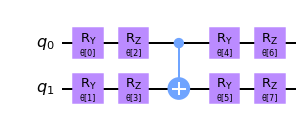

In [7]:


ansatz = EfficientSU2(hamiltonian.num_qubits, reps=n_layers)
ansatz.decompose().draw('mpl')

In [8]:
import numpy as np
from qiskit_algorithms.time_evolvers.variational import ImaginaryMcLachlanPrinciple
from qiskit_algorithms import TimeEvolutionProblem
from qiskit_algorithms import VarQITE
from qiskit.primitives import Estimator


In [9]:
t1=t.time()
init_param_values={}
for i in range(len(ansatz.parameters)):
    init_param_values[ansatz.parameters[i]]=np.pi/1.7
    
var_principle = ImaginaryMcLachlanPrinciple()
    
time = 5
aux_ops = [hamiltonian]
evolution_problem = TimeEvolutionProblem(hamiltonian, time, aux_operators=aux_ops)


var_qite = VarQITE(ansatz, init_param_values, var_principle, Estimator())
# an Estimator instance is necessary, if we want to calculate the expectation value of auxiliary operators.
evolution_result = var_qite.evolve(evolution_problem)
print(t.time()-t1)

15.969064950942993


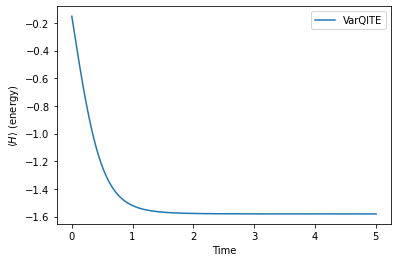

In [10]:
import pylab

h_exp_val = np.array([ele[0][0] for ele in evolution_result.observables])


times = evolution_result.times
pylab.plot(times, h_exp_val, label= "VarQITE")
pylab.xlabel("Time")
pylab.ylabel(r"$\langle H \rangle$ (energy)")
pylab.legend(loc="upper right");

Get the ground state into matrix form. 

Ground state is then the state created by acting $U_{ground}$ on the zero state

In [11]:
qr_g = QuantumRegister(n_qubits,'qr') #quantum register
qc_g = QuantumCircuit(qr_g) #construct ansatz
qc_g.compose(EfficientSU2(hamiltonian.num_qubits, reps=n_layers),inplace=True)
qc_g_assigned=qc_g.assign_parameters(evolution_result.parameter_values[-1])
U_ground=qi.Operator(qc_g_assigned)

Then we attempt to find the state created by $\rvert U(\theta)\lvert 0 \rangle$  that has no overlap with the ground state.

This could be obtained by minimizing 

$\langle 0 \rvert U^{\dagger}_{ground} U(\theta) \lvert 0 \rangle$ 

or 

$\langle 0 \rvert U(\theta)U^{\dagger}_{ground} \lvert 0 \rangle$ 

In [12]:
def callback_graph(x,name='loss'):
    #clear_output(wait=True)
    plt.title("Training curve")
    plt.xlabel("Iteration")
    plt.ylabel(name)
    plt.plot(range(len(x)), x)
    plt.show()
def countZero(x):
    out=f"{bin(x)}".count("1")
    if out==0:
        return 0
    else:
        return 1

In [13]:

def mkSampler(U_target):
    inputs = ParameterVector("input", 0)
    
    ansatz=EfficientSU2(hamiltonian.num_qubits, reps=1)
    params_index=0
    qc = QuantumCircuit(n_qubits)
    qr=qc.qubits
    A = [qr[i] for i in range(n_qubits)]

  

    qc.compose(ansatz,inplace=True)
                
                
    qc.unitary(dagger(U_target.to_matrix()),qubits=A, label='$U_{target}^{+}$')



    qc.barrier()
    sampler_qnn = SamplerQNN(circuit=qc,input_params=inputs, weight_params=ansatz.parameters,
                         interpret=countZero,output_shape=2
                        )
    return qc,sampler_qnn
    
    

In [14]:
qc,sampler=mkSampler(U_ground)

/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


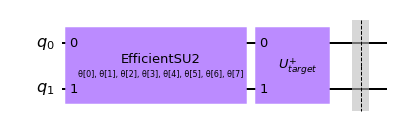

In [15]:
qc.draw('mpl')

My customized optimizer for fast convergence

In [16]:
def getMag(x):
    x2=x**2
    return np.sqrt(x2.sum())

def getI(cx,cy,x,y):
    cos=(x*y).sum()/(getMag(x)*getMag(y))
    return (1-cos)
def train(sampler,weights,learning_rate=1e-2,inputs=[]):
    cost=0
    for i,s in enumerate(sampler):
        out=s.forward(inputs, weights)
        cost+=out[0][0]
  
        input_grad,weight_grad = s.backward(inputs, weights)
        grad=weight_grad[0][0] 
        if i>0:
            grad+=weight_grad[0][0]
        weights-=learning_rate*grad
        
    gradMag= np.sqrt((grad**2).sum())
    return cost, weights,grad,gradMag
    
def myAlg(sampler,nSteps=100,learning_rate=1e-2,low=1e-2,high=1e-1,alpha=0.25,
                  threshold=1e-5,sampler_weights=None):
    sampler_input = np.array([])
    if sampler_weights is None:
        sampler_weights = algorithm_globals.random.random(sampler[0].num_weights)
        
    List={"cost":[],"rate":[],"grad":[],"I":[0]}
    
    for i in range(nSteps):
        if i%5==0:
            print(i)
        t1=t.time()
        cost, sampler_weights,grad,gradMag=train(sampler,sampler_weights,learning_rate=learning_rate)

        List['cost'].append(cost)
        List['grad'].append(grad)

        if i>1:
            I=getI(cost,List['cost'][-2],grad,List['grad'][-2])
            List['I'].append(I)
            if cost>0.1:
                if I<low:
                    learning_rate=learning_rate*(1+alpha)

                if I>high:
                    learning_rate=learning_rate*(1-alpha)
            else:
              
                if I<low:
                    learning_rate=learning_rate*(1+0.1*alpha)

                if I>high:
                    learning_rate=learning_rate*(1-0.1*alpha)
        List['rate'].append(learning_rate)
        if cost<1e-14:
            break
        if i%1==0:

            clear_output(wait=True)
            plt.figure(1)
            plt.yscale('log')
            callback_graph(List['cost'])
#             plt.figure(2)
#             plt.yscale('log')
#             callback_graph(List['rate'],"learning rate")
#             plt.figure(3)
#             plt.yscale('log')
#             callback_graph(List['I'],"I value")

        #print(t.time()-t1)

    return List,sampler_weights

In [17]:
def purge(U,sampler_weights=None):
    sampler_list=[]
    for u in U:
        qc,sampler=mkSampler(u)
        sampler_list.append(sampler)
        
    costList,weights=myAlg(sampler_list,sampler_weights=sampler_weights,nSteps=200,learning_rate=2e0)
    return weights

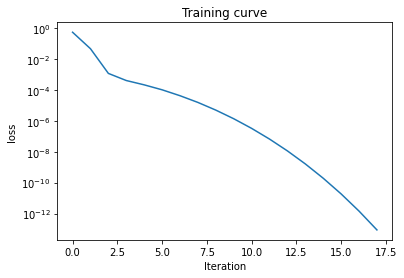

In [18]:
weights=purge([U_ground])


Checking that $\langle 0 \rvert U(\theta)U^{\dagger}_{ground} \lvert 0 \rangle$  is indeed minimized

In [19]:
UU_d=qi.Operator(qc.assign_parameters(weights))

In [20]:
abs(UU_d.to_matrix()[0][0])

1.1774028371362459e-08

Performing imaginary time evolution again, but with a initial state that is orthogonal to the ground state within computational accuracy.

First perform imaginary time with a purged initial state for a short period

In [21]:
time=1
init_param_values={}
for i in range(len(ansatz.parameters)):
    init_param_values[ansatz.parameters[i]]=weights[i]

aux_ops = [hamiltonian]
evolution_problem = TimeEvolutionProblem(hamiltonian, time, aux_operators=aux_ops)
var_qite = VarQITE(ansatz, init_param_values, var_principle, Estimator())
# an Estimator instance is necessary, if we want to calculate the expectation value of auxiliary operators.
evolution_result = var_qite.evolve(evolution_problem)

Now that it has evolved, the ground state is of greater coefficients. Purge again.

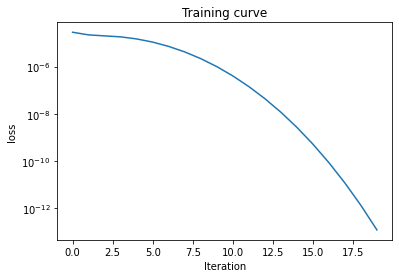

20


In [22]:
weights=purge([U_ground],sampler_weights=evolution_result.parameter_values[-1])

In [23]:
time=5
init_param_values={}
for i in range(len(ansatz.parameters)):
    init_param_values[ansatz.parameters[i]]=weights[i]

aux_ops = [hamiltonian]
evolution_problem = TimeEvolutionProblem(hamiltonian, time, aux_operators=aux_ops)
var_qite = VarQITE(ansatz, init_param_values, var_principle, Estimator())
# an Estimator instance is necessary, if we want to calculate the expectation value of auxiliary operators.
evolution_result = var_qite.evolve(evolution_problem)



/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Figure size 432x288 with 0 Axes>

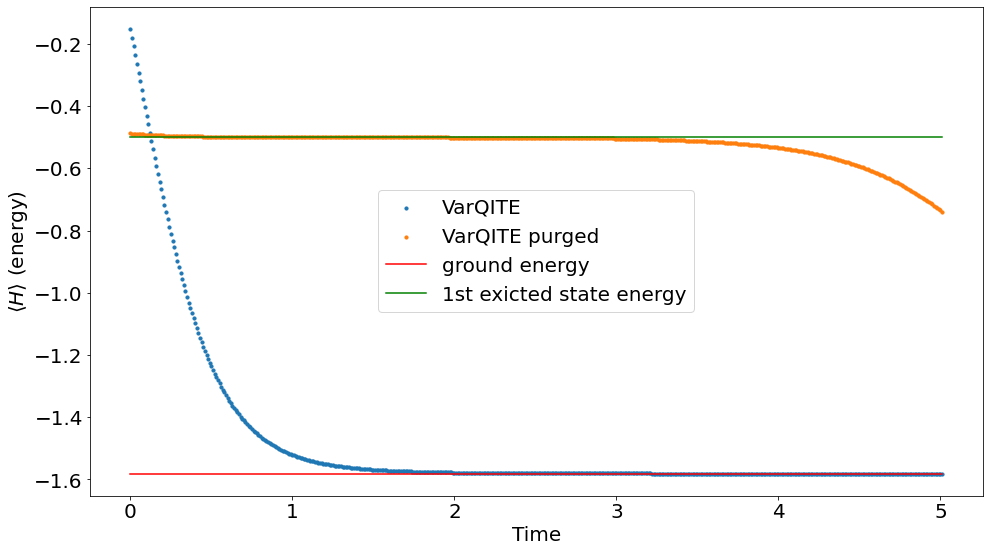

In [24]:
LabelSize=20
h_exp_val_ex = np.array([ele[0][0] for ele in evolution_result.observables])
times = evolution_result.times

plt.figure(1)
plt.figure(figsize=(16,9))
plt.scatter(times, h_exp_val, label= "VarQITE",s=10)
plt.scatter(times, h_exp_val_ex, label= "VarQITE purged",s=10)
plt.plot(times,[groudEnergy]*len(times),color='r',label='ground energy')
plt.plot(times,[exictedEnergy]*len(times),color='g',label='1st exicted state energy')
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.xlabel("Time",fontsize=LabelSize)
plt.ylabel(r"$\langle H \rangle$ (energy)",fontsize=LabelSize)
plt.legend(fontsize=LabelSize);
plt.savefig("VarQITE_purging.pdf")

Obtaining the first exicted state

In [25]:
diff=abs(h_exp_val_ex-exictedEnergy)
index=np.where(diff==diff.min())[0][0]

qr_g = QuantumRegister(n_qubits,'qr') #quantum register
qc_g = QuantumCircuit(qr_g) #construct ansatz
qc_g.compose(EfficientSU2(hamiltonian.num_qubits, reps=n_layers),inplace=True)
qc_g_assigned=qc_g.assign_parameters(evolution_result.parameter_values[index])
U_1=qi.Operator(qc_g_assigned)

Purge both ground and first excited state

In [26]:
def getEigen(U_list,time_stamp=np.array([0.5,0.5,0.5,0.5,5])):
    weights=purge(U_list)
    for i,time in enumerate(time_stamp):
        init_param_values={}
        for j in range(len(ansatz.parameters)):
            init_param_values[ansatz.parameters[j]]=weights[j]

        aux_ops = [hamiltonian]
        evolution_problem = TimeEvolutionProblem(hamiltonian, time, aux_operators=aux_ops)
        var_qite = VarQITE(ansatz, init_param_values, var_principle, Estimator())
        # an Estimator instance is necessary, if we want to calculate the expectation value of auxiliary operators.
        evolution_result = var_qite.evolve(evolution_problem)
        if i<(len(time_stamp)-1):
            weights=purge([U_list[0]],sampler_weights=evolution_result.parameter_values[-1])
        
    return evolution_result,weights

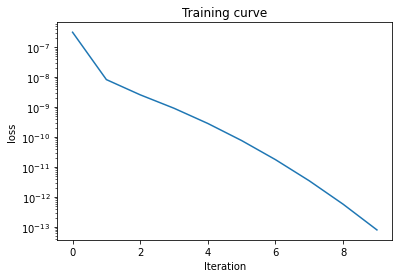

10


In [27]:
evolution_result,weights=getEigen([U_ground,U_1])

/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Figure size 432x288 with 0 Axes>

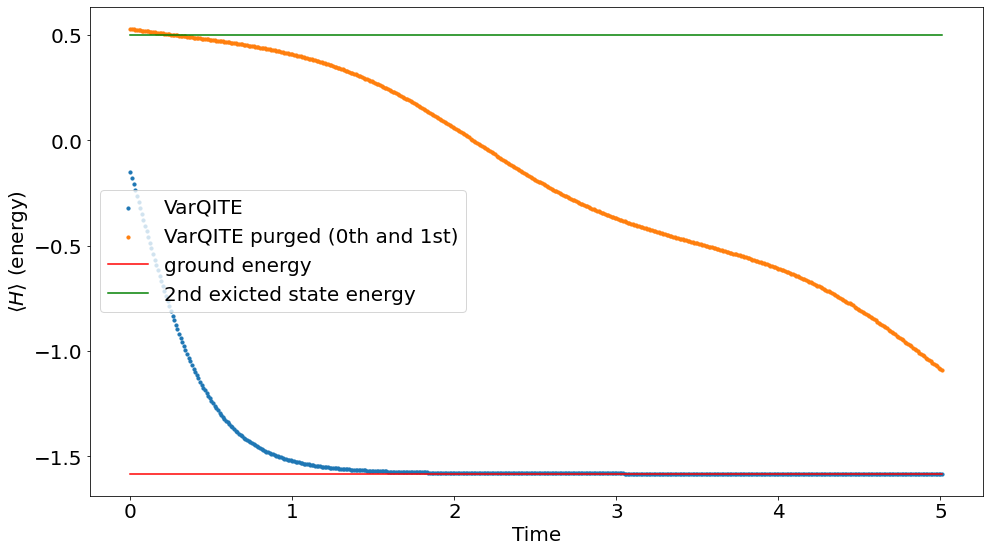

In [28]:
LabelSize=20
h_exp_val_ex = np.array([ele[0][0] for ele in evolution_result.observables])
times = evolution_result.times

plt.figure(1)
plt.figure(figsize=(16,9))
plt.scatter(times, h_exp_val, label= "VarQITE",s=10)
plt.scatter(times, h_exp_val_ex, label= "VarQITE purged (0th and 1st)",s=10)
plt.plot(times,[groudEnergy]*len(times),color='r',label='ground energy')
plt.plot(times,[exictedEnergy2]*len(times),color='g',label='2nd exicted state energy')
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.xlabel("Time",fontsize=LabelSize)
plt.ylabel(r"$\langle H \rangle$ (energy)",fontsize=LabelSize)
plt.legend(fontsize=LabelSize);
plt.savefig("VarQITE_purging_2nd.pdf")

Last Eigen

In [29]:
time_stamp=abs(times-1)
index=np.where(time_stamp==time_stamp.min())[0][0]

qr_g = QuantumRegister(n_qubits,'qr') #quantum register
qc_g = QuantumCircuit(qr_g) #construct ansatz
qc_g.compose(EfficientSU2(hamiltonian.num_qubits, reps=n_layers),inplace=True)
qc_g_assigned=qc_g.assign_parameters(evolution_result.parameter_values[index])
U_2=qi.Operator(qc_g_assigned)

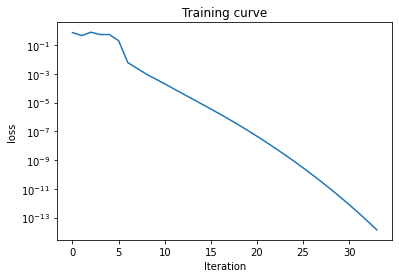

In [30]:
weight_last=purge([U_ground,U_1,U_2])

In [31]:
qr_g = QuantumRegister(n_qubits,'qr') #quantum register
qc_g = QuantumCircuit(qr_g) #construct ansatz
qc_g.compose(EfficientSU2(hamiltonian.num_qubits, reps=n_layers),inplace=True)
qc_g_assigned=qc_g.assign_parameters(weight_last)

In [32]:
U_3=qi.Operator(qc_g_assigned)

In [33]:
HU=np.matmul(hamiltonian.to_matrix(),U_3)

In [34]:
UHU=np.matmul(dagger(U_3),HU)

In [35]:
abs(UHU[0][0])

1.5754814551479541

In [36]:
eigenValues[-1]

(1.5811388300841898+0j)